In [ ]:
!pip install pyro-ppl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import pyro
pyro.__version__

'1.5.0'

In [ ]:
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam

# 1.Read data

In [ ]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  4113k      0  0:00:01  0:00:01 --:--:-- 4113k
Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100

## 1.1 Format data

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def cal_silhoutte(X, cluster_labels):
    silhouette_score = silhouette_samples(X, cluster_labels)
    return silhouette_score

def cal_KMEANS_labels(X, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    return cluster_labels

def visualize_clusters(X, n_clusters = 6, cluster_labels = None, \
                                                scoring_method='silhouette'):
    if cluster_labels is None:
        cluster_labels = cal_KMEANS_labels(X, n_clusters)

    score, score_avg = None, None
    if scoring_method =='silhouette':
        score = cal_silhoutte(X, cluster_labels)
        score_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "the average %s score is : %.2f" \
                                            % (scoring_method, score_avg))

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 3)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = score[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Plot for the various clusters.")
    ax1.set_xlabel("The % score" % scoring_method)
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=score_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [ ]:
data_full = pd.read_csv('./ml-100k/u.data', sep='\t', names=['USER_ID','ITEM_ID','RATING','TIMESTAMP'])
print (data_full.info())
data_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   USER_ID    100000 non-null  int64
 1   ITEM_ID    100000 non-null  int64
 2   RATING     100000 non-null  int64
 3   TIMESTAMP  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
None


,USER_ID,ITEM_ID,RATING,TIMESTAMP
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
ITEM_COL_NAMES = ['ITEM_ID', 'TITLE', 'Release Data', 'Video Release Date', 'IMDb URL', 'unknown', 'Action', 'Adventre', 'Animation', \
                  'Childen', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', \
                  'Sci-Fi', 'Thriller', 'War', 'Western']
product_id = pd.read_csv('./ml-100k/u.item', sep='|', names=ITEM_COL_NAMES, error_bad_lines=False, encoding='latin-1')
product_id.head()

,ITEM_ID,TITLE,Release Data,Video Release Date,IMDb URL,unknown,Action,Adventre,Animation,Childen,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## 1.2 Pre-process data

In [ ]:
def create_mapping(list1, list2):
	return dict(zip(list1, list2))
def convert_mapping(mapping, encode_list):
	return list(map(lambda x: mapping[x], encode_list))

from gensim import corpora

def prepare_mapping(product_lists):
    id2word = corpora.Dictionary(product_lists)
    corpus = [id2word.doc2bow(w) for w in product_lists]
    # all_products = np.array([item[1] for item in id2word.items()])
    return id2word, corpus

def gettopidx_row(x, NTOP):
    res = np.argsort(x)[:NTOP+1] # recommending list includes NTOP+1: itself and NTOP others
    return res

def gettopidx_eachrow_matrix(arr, NTOP, metric='sim'):
    if metric == 'distance': #similarity or score
        return np.apply_along_axis(gettopidx_row, 1, arr, NTOP) #get top of arr after ascending  sort
    return np.apply_along_axis(gettopidx_row, 1, -arr, NTOP)      #get top of arr after descending sort

def keeppositive_idx(arr):
    x, y = np.where(arr >= 0) # filter itself and invalid values
    return x, y

def filteridx_matrix(rec_metric, NTOP, metric):
    '''
        - Sorted and limit NTOP idx of each row
        - Remove <= 0 idx of each row
        - Return idx of arr
    '''
    top_idx = gettopidx_eachrow_matrix(rec_metric, NTOP, metric)
    top_value = np.array([rec_metric[i, top_idx[i]] for i in range(len(top_idx))])
    x, y = keeppositive_idx(top_value)
    return x, top_idx[x, y]

def euclid_distance(x, y): #x, y: vector with shape (-1, 1)
    return np.sum((x-y)**2)

In [ ]:
# STOCK_CODEDES = (product_id.StockCode.unique(), stock2dec_mapping)

class IndexStocks:
    def __init__(self, STOCK_CODEDES):
        stockcode_arr, stock2dec_mapping = STOCK_CODEDES
        self.stockcode_arr = stockcode_arr
        self.mapping = stock2dec_mapping

    def get_itemidx(self, items):
        find_items = lambda x: np.where(np.array(self.stockcode_arr)==x)[0][0]
        idx_items = np.apply_along_axis(find_items, 1, np.array(items).reshape(-1, 1))
        return idx_items

    def gettoprec_byid(self, idx_start_items, rec_matrix, metric, NTOP=5):
        items, rec_items = filteridx_matrix(rec_matrix, NTOP, metric=metric)
        return pd.DataFrame({'start_code':np.array(self.stockcode_arr)[idx_start_items[items]], \
                             'rec_code':np.array(self.stockcode_arr)[rec_items], \
                             'distance':rec_matrix[items, rec_items]})

    def add_description(self, rec_df):
        rec_df['start_des'] = convert_mapping(self.mapping, rec_df['start_code'])
        rec_df['rec_des'] = convert_mapping(self.mapping, rec_df['rec_code'])
        return rec_df

class Item2Item_REC():
    def __init__(self, products_prob, STOCK_CODEDES):
        self.idx_parser = IndexStocks(STOCK_CODEDES)
        self.products_prob = products_prob
        self.full_simmatrix = None

    def __cal_recdistance(self, x):
        cal_sim = lambda y: euclid_distance(x.reshape(-1, 1), y.reshape(-1, 1))
        np_sim = np.apply_along_axis(cal_sim, 1, self.products_prob)
        return np_sim.reshape(-1)

    def get_full_simmatrix(self):
        if self.full_simmatrix is None:
            self.full_simmatrix = self.cal_recscore(range(len(products_prob)))
        return self.full_simmatrix

    def cal_recdistance(self, idx_start_items):
        return np.apply_along_axis(self.__cal_recdistance, 1, self.products_prob[idx_start_items, :])

    def recommend(self, start_items, NTOP=5):
        idx_start_items = self.idx_parser.get_itemidx(start_items)
        sim_matrix = self.cal_recdistance(idx_start_items)
        return self.idx_parser.gettoprec_byid(idx_start_items, sim_matrix, metric='distance', NTOP=NTOP)

In [ ]:
n_invoice = data_full['USER_ID'].nunique()
n_product = data_full['ITEM_ID'].nunique()
interaction_matrix = np.zeros((n_invoice, n_product))
for i in range(n_invoice):
    prods = np.array(data_full[data_full['USER_ID']==i]['ITEM_ID']).astype(int)-1
    rates = np.array(data_full[data_full['USER_ID']==i]['RATING']).astype(int)
    interaction_matrix[np.array([i]*len(prods)).astype(int)-1, prods] = rates
interaction_matrix.shape

(943, 1682)

In [ ]:
invoice_mapping = create_mapping(data_full['USER_ID'].unique(), data_full['USER_ID'].unique()-1)
stock2dec_mapping = create_mapping(np.array(product_id.ITEM_ID)-1, product_id.TITLE)
STOCK_CODEDES = (product_id.ITEM_ID.unique(), stock2dec_mapping)

In [ ]:
import torch

vmin, vmax = np.min(interaction_matrix), np.max(interaction_matrix)
vmin = 1
# del ratings
# del Identity
scale_rating = (interaction_matrix-vmin)/(vmax-vmin)
ratings = torch.from_numpy(scale_rating).float()
''' normalize values by items - experiences show that it leads to increase MAE '''
for j in range(scale_rating.shape[1]):
    scale_rating[:, j] = scale_rating[:, j]/np.sum(scale_rating[:, j])
Identity = torch.from_numpy(scale_rating).float()
del scale_rating
print (ratings.shape, Identity.shape)

torch.Size([943, 1682]) torch.Size([943, 1682])


# 2.Functions

### model's functions

In [ ]:
def scale_minmax(x):
    vmin, vmax = torch.min(x), torch.max(x)
    return (x - vmin)/(vmax-vmin)

In [ ]:
def sgd_training(model, loss_fn, obs, epochs=500):
    pyro.clear_param_store()
    optim   = torch.optim.Adam(model.parameters(), lr=0.01)

    view_step = epochs/10
    loss_track, param_track = [], []

    for step in range(epochs):
        # Computing Loss
        y = model().squeeze(-1) #model.forward(), squeeze ~ reshape(,-1)
        loss = loss_fn(y, obs)
        loss_track.append(loss.item())
        param_track.append(model.get_param())

        # Tracking
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Epoch %d: " % step)
            r = model.get_approx()
            rmse = np.sqrt(np.mean((r.data.numpy() - obs.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', param_track[-1])
            if (loss < 0):
                print ("----Early stopping----")
                break

        # Optimizing
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_track, param_track

from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI
from pyro.infer.autoguide import AutoDiagonalNormal

def svi_training(model, guide, obs, epochs=100):
    pyro.clear_param_store()

    adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
    optimizer = Adam(adam_params)

    svi = SVI(model, guide, optimizer, loss=Trace_ELBO(retain_graph=True))

    epochs  = 100
    view_step = epochs/10

    loss_track, param_track = [], []
    for step in range(epochs):
        loss = svi.step(obs)
        loss_track.append(loss)
        params = model.get_param()
        param_track.append(params)
        if (loss < 0) or (step==0) or (step % view_step == view_step-1):
            print ("Step %d" % step)
            r = dist.Normal(torch.tensor([params['phi']]), torch.tensor([params['tau']])).sample([1000])
            rmse = np.sqrt(np.mean((r.data.numpy() - arr.data.numpy())**2))
            print ('+ Loss = %.6f, RMSE = %.6f ' % (loss, rmse))
            print ('+ Param: ', params)
            if loss < 0:
                print ('early stopping')
                break
    return loss_track, param_track

In [ ]:
def get_mulogvar(x):
    mu, log_var = torch.mean(x), torch.log(torch.var(x))
    return mu, log_var

def log_norm2(x, mu, log_var):
    #similar log_norm2, but generate log_var instead var
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    # return -0.5 * torch.log(2*np.pi*var) -(0.5 * (1/var)* (x-mu)**2)
    return -0.5 * (log_var + np.log(2*np.pi)) -(0.5 * (1/torch.exp(log_var))* (x-mu)**2)

In [ ]:
class SGD_MCTrick(torch.nn.Module):
    def __init__(self):
        super(SGD_MCTrick, self).__init__()
        self.phi = torch.tensor(0.0) #mean = 0
        self.tau = torch.nn.Parameter(torch.randn(1), requires_grad=True)
        self.tau.data.fill_(1.0) #log_std, arbitrarily init
        self.x = self.generate()

    def generate(self, n_sample=1000):
        eps = scale_minmax(torch.randn(n_sample))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        # eps = torch.randn(self.dim)
        # x_hat = self.phi + torch.exp(self.tau) * eps
        return x_hat

    def forward(self):
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
# see torch.nn.KLDivLoss
class KLDiv_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(KLDiv_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        return torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)

class ELBO_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(ELBO_Loss, self).__init__(size_average, reduce, reduction)
        self.log_target = log_target
        # self.KL_Div = KLDiv_Loss(size_average, reduce, reductio, log_target = True)

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)
        kl_div = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = log_norm2(target, mu_q, logvar_q)
        if self.reduction == 'mean':
            reconstruct_loss = torch.mean(log_p)
        else:
            reconstruct_loss = torch.sum(log_p)
        elbo = reconstruct_loss - kl_div
        return -elbo

class Combining_Loss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', log_target: bool = False):
        super(Combining_Loss, self).__init__(size_average = size_average, reduce = reduce, reduction = reduction)
        self.log_target = log_target

    def forward(self, input, target):
        mu_p, logvar_p = get_mulogvar(target)
        log_p = log_norm2(target, mu_p, logvar_p)
        mu_q, logvar_q = get_mulogvar(target)
        log_q = log_norm2(input, mu_q, logvar_q)

        kl_loss = torch.nn.functional.kl_div(log_q, log_p, reduction=self.reduction, log_target=self.log_target)
        reconstruct_loss = torch.nn.functional.mse_loss(input, target, reduction=self.reduction)

        loss = -(reconstruct_loss - kl_loss)
        return loss

### learning visualization

In [ ]:
param_track[0]

{'logvar_R_param': 0.0,
 'logvar_V_param': array([0.6399658 , 0.5872465 , 0.6536426 , 0.6723696 , 0.633024  ,
        0.7079741 , 0.7028039 , 0.6749332 , 0.5986722 , 0.5788602 ,
        0.6319339 , 0.65073085, 0.707625  , 0.7319073 , 0.62210137,
        0.6511668 ], dtype=float32),
 'logvar_W_param': array([0.70763594, 0.65091985, 0.7071004 , 0.7323392 , 0.66282964,
        0.78351206, 0.75440705, 0.75961506, 0.632898  , 0.6517075 ,
        0.66936815, 0.6892012 , 0.7822233 , 0.79069984, 0.7240053 ,
        0.7339293 ], dtype=float32),
 'logvar_Y_param': array([0.6326412 , 0.6971729 , 0.6839048 , 0.6632062 , 0.70510244,
        0.6701016 , 0.7003921 , 0.6937116 , 0.6877575 , 0.67552537,
        0.6722757 , 0.6740026 , 0.664833  , 0.6672561 , 0.67707443,
        0.6118808 ], dtype=float32)}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sbn

def visualize_learning(param_track, approx):
    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [np.exp(param[param_name]) for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
        print (param_name, param_value)
        break
    plt.hist(approx)
    plt.show()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_values_from_param(param, size, mean_value=0.0):
    # latent = np.random.normal(loc=param, scale = scale_latent, size = size)
    value = np.random.normal(loc = mean_value, scale = param, size = size)
    return value

def visualize(loss_track, param_track, approx):
    plt.plot(range(len(loss_track)), loss_track)
    plt.title('Loss')
    plt.show()

    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [param[param_name] for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
    plt.hist(approx)
    plt.show()

In [ ]:
def get_values_from_tracker(Identity, K, param_dict):
    N, M = Identity.shape
    V = get_values_from_param(np.exp(0.5*param_dict['logvar_V_param']), (M, K))
    W = get_values_from_param(np.exp(0.5*param_dict['logvar_W_param']), (M, K))
    Y = get_values_from_param(np.exp(0.5*param_dict['logvar_Y_param']), (N, K))
    avg_similarity_weight = np.matmul(np.array(Identity.data.numpy()).astype(float), W)
    U = Y + avg_similarity_weight
    R = get_values_from_param(np.exp(0.5*param_dict['logvar_R_param']), (N, M), mean_value = sigmoid(np.matmul(U, V.T)))
    # print (R.shape, V.shape, U.shape, W.shape, Y.shape)
    return R, V, U, W, Y

# 3.Matrix Factorization

In [ ]:
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.distributions as dist

## 3.1 Pytorch+Pyro model

(array([  2.,  16.,  70., 177., 290., 222., 169.,  43.,   9.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

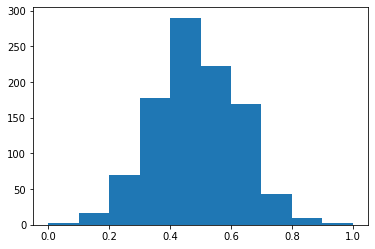

In [ ]:
arr = scale_minmax(torch.randn(1000))
arr.shape
plt.hist(arr.data.numpy())

In [ ]:
def invscale_minmax(x, vmin, vmax):
    return x * (vmax - vmin) + vmin

In [ ]:
class Neural_PMF(PyroModule):
    def __init__(self, Identity, latent=16, mean=0.0, sd=1.0):
        super().__init__()
        user_dim, item_dim = Identity.shape
        self.user_dim, self.item_dim, self.latent_dim = user_dim, item_dim, latent
        self.Identity = Identity

        self.logvar_V_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)#PyroParam(dist.Normal(mean, sd))
        self.logvar_W_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)#PyroParam(dist.Normal(mean, sd))
        self.logvar_U_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)#PyroParam(dist.Normal(mean, sd))
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)#PyroParam(dist.Normal(mean, sd))

        self.U, self.W, self.Y, self.R = None, None, None, None

    def generate(self, latent=16, mean=3.0, sd=0.15):
        self.V = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_V_param)).expand([self.item_dim, self.latent_dim]).to_event(2))
        self.W = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_W_param)).expand([self.item_dim, self.latent_dim]).to_event(2))
        self.Y = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_U_param)).expand([self.user_dim, self.latent_dim]).to_event(2))
        avg_similarity_weight = torch.mm(self.Identity, self.W)
        self.U = self.Y + avg_similarity_weight
        self.mean_R = torch.sigmoid(torch.mm(self.U, self.V.T))
        self.R = PyroSample(dist.Normal(loc=self.mean_R, scale=torch.exp(0.5*self.logvar_R_param)))
        return self.R

    def get_param(self):
        return {'logvar_V_param':self.logvar_V_param.item(), 'logvar_W_param':self.logvar_W_param.item(),\
                'logvar_Y_param':self.logvar_U_param.item(), 'logvar_R_param':self.logvar_R_param.item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

### ELBO Loss

In [ ]:
model = Neural_PMF(Identity)
loss_track, param_track = sgd_training(model, ELBO_Loss(), ratings, epochs=1500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 7.721111, RMSE = 1.320652 
+ Param:  {'logvar_V_param': 0.0, 'logvar_W_param': 0.0, 'logvar_Y_param': 0.0, 'logvar_R_param': 0.0}
Epoch 149: 
+ Loss = 3.775492, RMSE = 0.960432 
+ Param:  {'logvar_V_param': -1.717041015625, 'logvar_W_param': -1.7130239009857178, 'logvar_Y_param': -1.6609214544296265, 'logvar_R_param': -1.1558151245117188}
Epoch 299: 
+ Loss = 2.618201, RMSE = 0.841031 
+ Param:  {'logvar_V_param': -2.8942389488220215, 'logvar_W_param': -2.916814088821411, 'logvar_Y_param': -2.7184243202209473, 'logvar_R_param': -1.8489611148834229}
Epoch 449: 
+ Loss = 2.256629, RMSE = 0.797884 
+ Param:  {'logvar_V_param': -3.418494462966919, 'logvar_W_param': -3.4560718536376953, 'logvar_Y_param': -3.1768157482147217, 'logvar_R_param': -2.3412489891052246}
Epoch 599: 
+ Loss = 2.070204, RMSE = 0.776401 
+ Param:  {'logvar_V_param': -3.744626522064209, 'logvar_W_param': -3.7932562828063965, 'logvar_Y_param': -3.4555866718292236, 'logvar_R_param': -2.7251713275909424

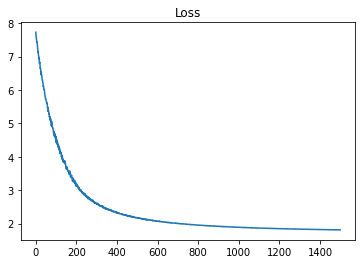

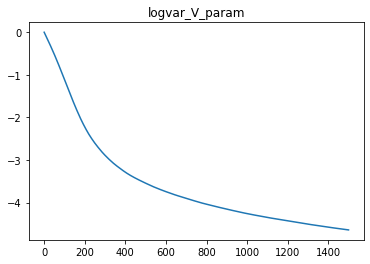

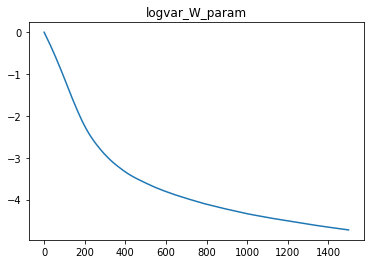

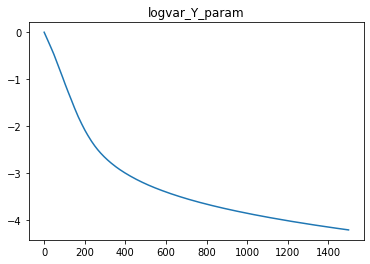

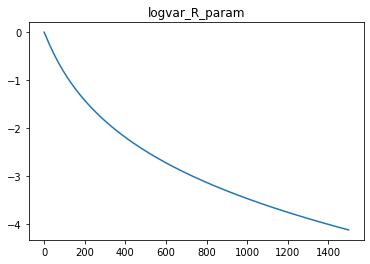

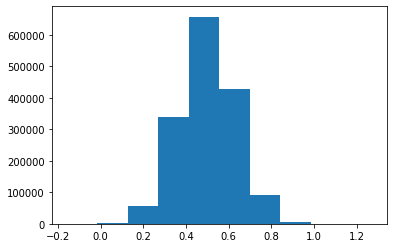

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

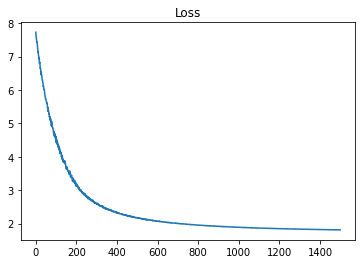

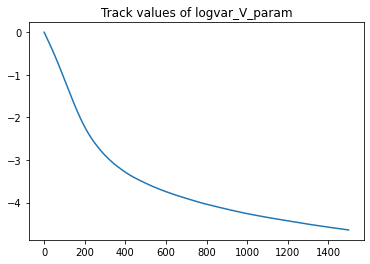

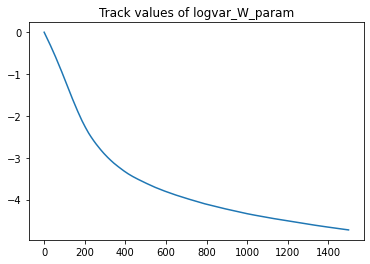

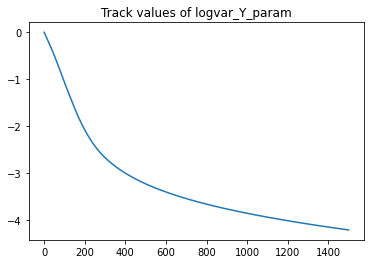

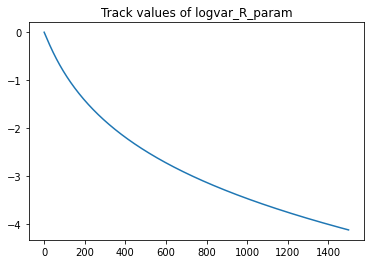

MAE_int:  0.05360229893463697
RMSE_int:  0.46304340589036347
MAE_float:  2.88190375225049
RMSE_float:  2.9666620994251254
For n_clusters = 6 the average silhouette score is : 0.04


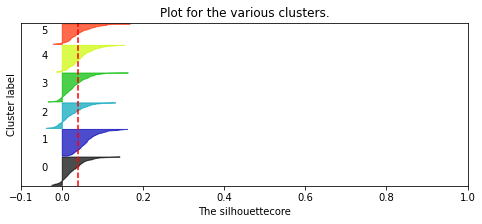

For n_clusters = 6 the average silhouette score is : 0.04


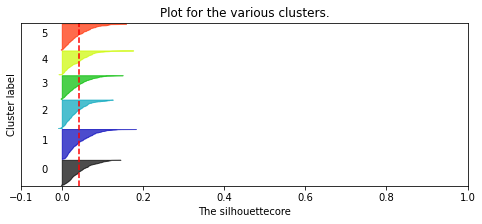

For n_clusters = 6 the average silhouette score is : 0.30


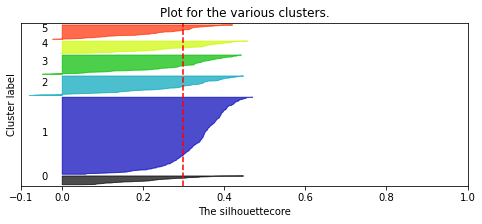

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = visualize_learning(param_track)

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

### MSE Loss

In [ ]:
model = Neural_PMF(Identity)
loss_track, param_track = sgd_training(model, torch.nn.MSELoss(), ratings, epochs=1500)

Epoch 0: 
+ Loss = 1.746382, RMSE = 1.320149 
+ Param:  {'logvar_V_param': 0.0, 'logvar_W_param': 0.0, 'logvar_Y_param': 0.0, 'logvar_R_param': 0.0}
Epoch 149: 
+ Loss = 0.944891, RMSE = 0.965503 
+ Param:  {'logvar_V_param': -1.712303638458252, 'logvar_W_param': -1.712813377380371, 'logvar_Y_param': -1.6521008014678955, 'logvar_R_param': -1.1559885740280151}
Epoch 299: 
+ Loss = 0.708893, RMSE = 0.840043 
+ Param:  {'logvar_V_param': -2.90385103225708, 'logvar_W_param': -2.9267570972442627, 'logvar_Y_param': -2.7357945442199707, 'logvar_R_param': -1.849168062210083}
Epoch 449: 
+ Loss = 0.634348, RMSE = 0.796659 
+ Param:  {'logvar_V_param': -3.4402263164520264, 'logvar_W_param': -3.4796009063720703, 'logvar_Y_param': -3.198596477508545, 'logvar_R_param': -2.3415913581848145}
Epoch 599: 
+ Loss = 0.602012, RMSE = 0.776341 
+ Param:  {'logvar_V_param': -3.765368700027466, 'logvar_W_param': -3.8151943683624268, 'logvar_Y_param': -3.4770684242248535, 'logvar_R_param': -2.725517749786377}

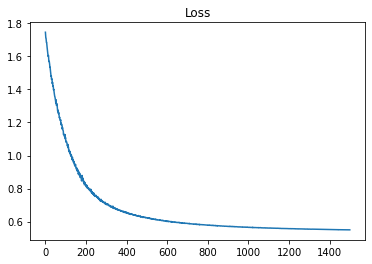

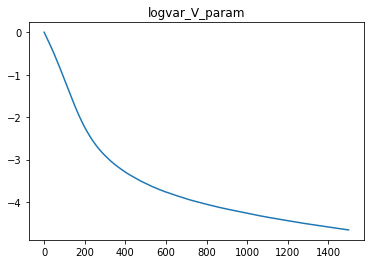

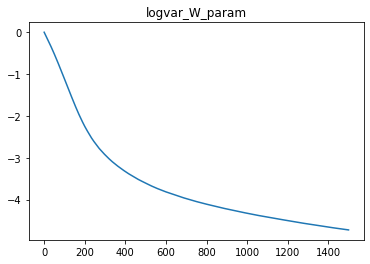

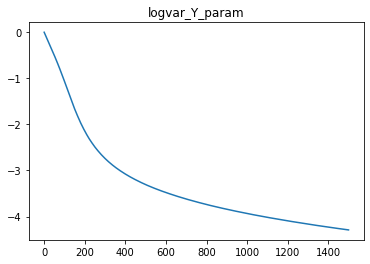

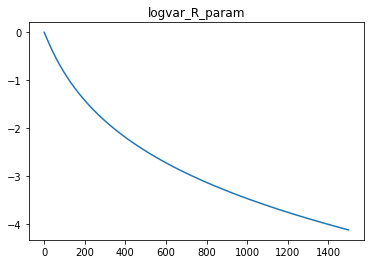

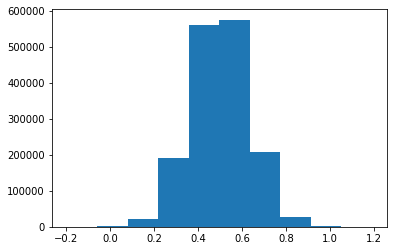

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

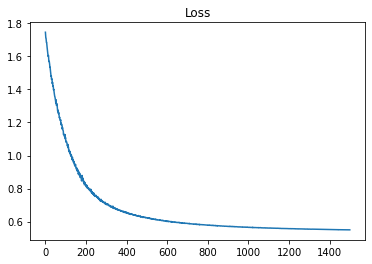

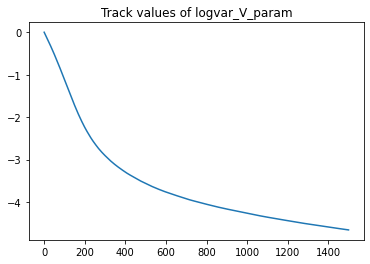

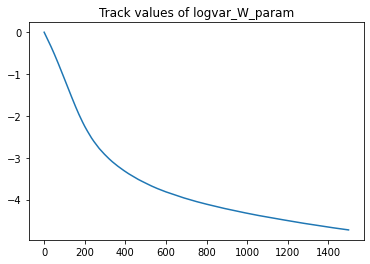

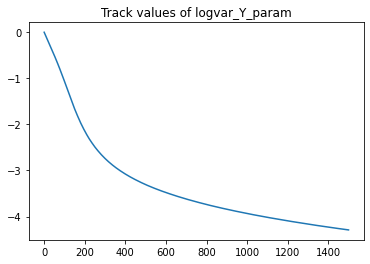

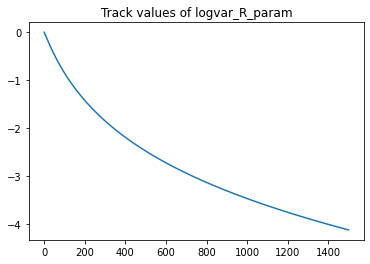

MAE_int:  0.053559427182960244
RMSE_int:  0.46285819505745057
MAE_float:  2.8815021022621607
RMSE_float:  2.965931669043247
For n_clusters = 6 the average silhouette score is : 0.04


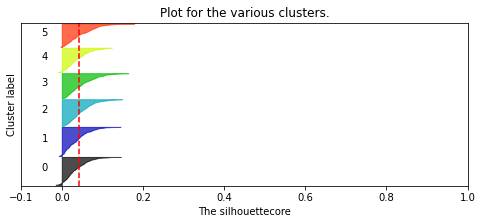

For n_clusters = 6 the average silhouette score is : 0.04


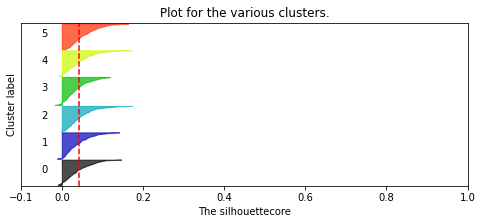

For n_clusters = 6 the average silhouette score is : 0.24


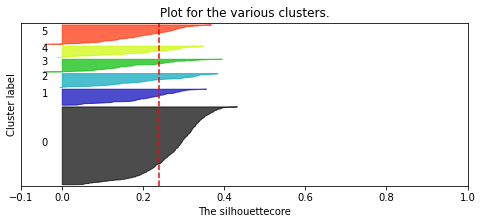

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = visualize_learning(param_track)

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

### KLDiv

In [ ]:
model = Neural_PMF(Identity)
loss_track, param_track = sgd_training(model, KLDiv_Loss(), ratings, epochs=1500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 7.827598, RMSE = 1.318202 
+ Param:  {'logvar_V_param': 0.0, 'logvar_W_param': 0.0, 'logvar_Y_param': 0.0, 'logvar_R_param': 0.0}
Epoch 149: 
+ Loss = 3.714048, RMSE = 0.967969 
+ Param:  {'logvar_V_param': -1.7162408828735352, 'logvar_W_param': -1.7179489135742188, 'logvar_Y_param': -1.637773036956787, 'logvar_R_param': -1.156002402305603}
Epoch 299: 
+ Loss = 2.668180, RMSE = 0.840984 
+ Param:  {'logvar_V_param': -2.9093987941741943, 'logvar_W_param': -2.9438490867614746, 'logvar_Y_param': -2.6843557357788086, 'logvar_R_param': -1.8490532636642456}
Epoch 449: 
+ Loss = 2.305697, RMSE = 0.797499 
+ Param:  {'logvar_V_param': -3.439842462539673, 'logvar_W_param': -3.49009108543396, 'logvar_Y_param': -3.143907070159912, 'logvar_R_param': -2.3414933681488037}
Epoch 599: 
+ Loss = 2.133001, RMSE = 0.777469 
+ Param:  {'logvar_V_param': -3.7535574436187744, 'logvar_W_param': -3.8105785846710205, 'logvar_Y_param': -3.424586057662964, 'logvar_R_param': -2.7253193855285645

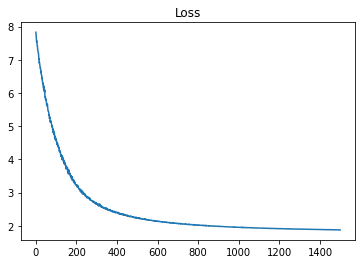

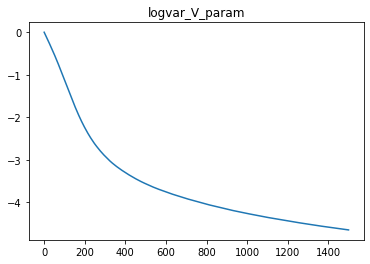

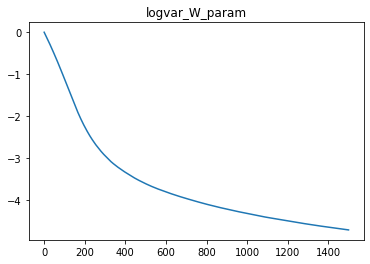

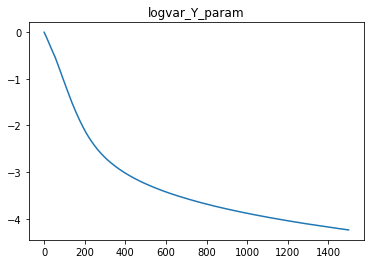

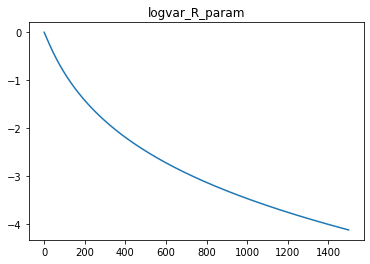

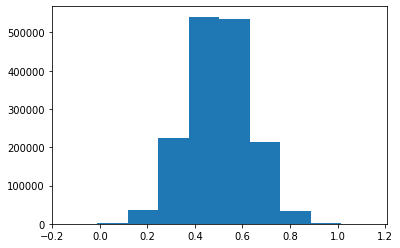

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

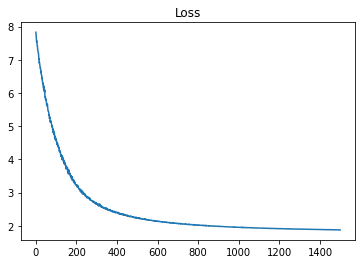

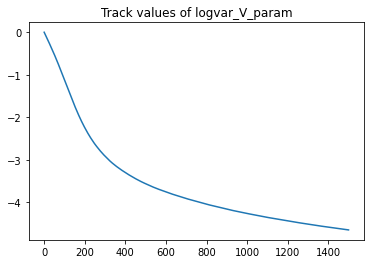

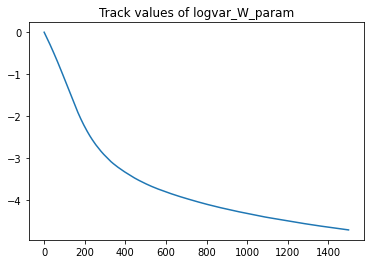

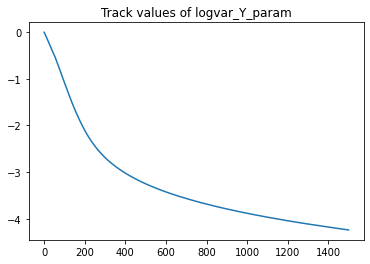

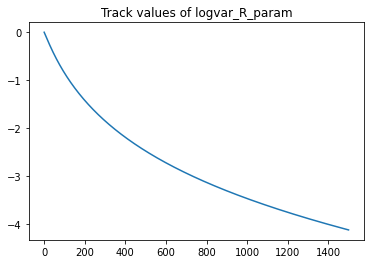

MAE_int:  0.05362751761209387
RMSE_int:  0.46315231884162633
MAE_float:  2.881743631553887
RMSE_float:  2.966052037904385
For n_clusters = 6 the average silhouette score is : 0.04


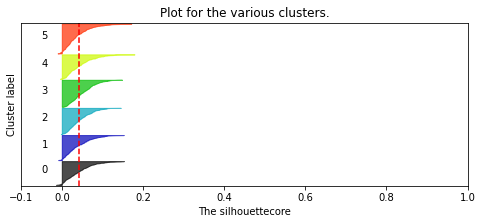

For n_clusters = 6 the average silhouette score is : 0.04


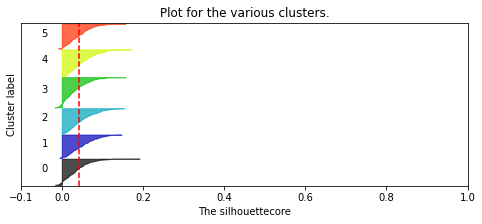

For n_clusters = 6 the average silhouette score is : 0.19


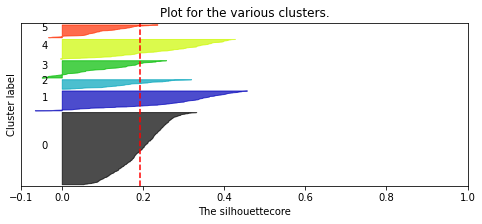

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = visualize_learning(param_track)

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

### ***Model-2***

In [ ]:
class Neural_PMF_2(PyroModule):
    def __init__(self, Identity, latent=16, mean=0.0, sd=1.0):
        super().__init__()
        user_dim, item_dim = Identity.shape
        self.user_dim, self.item_dim, self.latent_dim = user_dim, item_dim, latent
        self.Identity = Identity

        self.logvar_V_param  = torch.nn.Parameter(torch.ones(self.latent_dim), requires_grad=True)
        self.logvar_W_param  = torch.nn.Parameter(torch.ones(self.latent_dim), requires_grad=True)
        self.logvar_U_param  = torch.nn.Parameter(torch.ones(self.latent_dim),requires_grad=True)
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)

        self.U, self.W, self.Y, self.R = None, None, None, None

    def generate(self, latent=16, mean=3.0, sd=0.15):
        self.V = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_V_param)).expand([self.item_dim, self.latent_dim]).to_event(1))
        self.W = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_W_param)).expand([self.item_dim, self.latent_dim]).to_event(1))
        self.Y = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_U_param)).expand([self.user_dim, self.latent_dim]).to_event(1))
        avg_similarity_weight = torch.mm(self.Identity, self.W)
        self.U = self.Y + avg_similarity_weight
        self.mean_R = torch.sigmoid(torch.mm(self.U, self.V.T))
        self.R = PyroSample(dist.Normal(loc=self.mean_R, scale=torch.exp(0.5*self.logvar_R_param)))
        return self.R

    def get_param(self):
        return {'logvar_V_param':0.0+self.logvar_V_param.data.numpy(), 'logvar_W_param':0.0+self.logvar_W_param.data.numpy(),\
                'logvar_Y_param':0.0+self.logvar_U_param.data.numpy(), 'logvar_R_param':0.0+self.logvar_R_param.item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

In [ ]:
model = Neural_PMF_2(Identity)
loss_track, param_track = sgd_training(model, ELBO_Loss(), ratings, epochs=1500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 16.415562, RMSE = 1.867375 
+ Param:  {'logvar_V_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_W_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_Y_param': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32), 'logvar_R_param': 1.0}
Epoch 149: 
+ Loss = 6.961055, RMSE = 1.259939 
+ Param:  {'logvar_V_param': array([-0.17564374, -0.19589214, -0.2151182 , -0.28253782, -0.24870369,
       -0.37534243, -0.2723965 , -0.19798008, -0.23170274, -0.15539674,
       -0.12155373, -0.16015731, -0.22542486, -0.14770268, -0.14168349,
       -0.2215013 ], dtype=float32), 'logvar_W_param': array([ 0.04769572,  0.0200513 , -0.07802588, -0.12959273, -0.08322345,
       -0.19516784, -0.08435941,  0.00946855, -0.09439512,  0.03117721,
        0.03567529,  0.00447595, -0.01568442,  0.02901896,  0.01451142,
       -0.02165186]

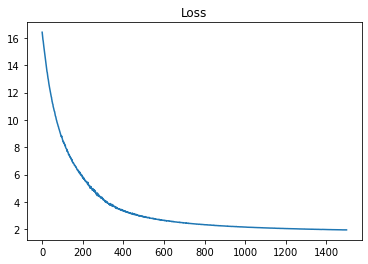

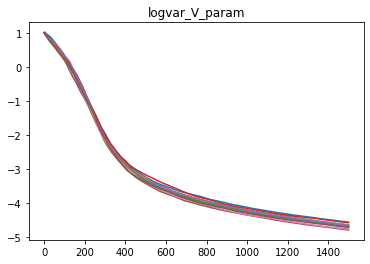

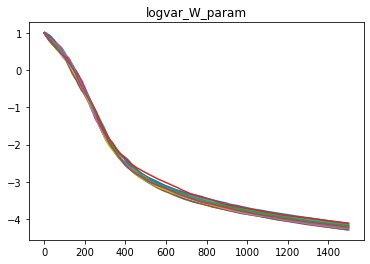

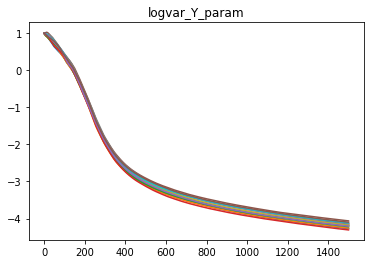

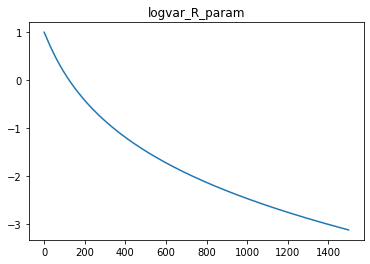

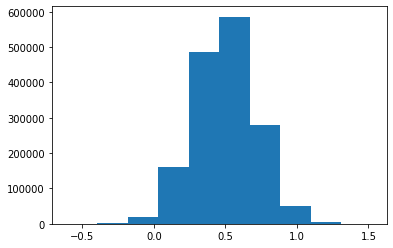

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

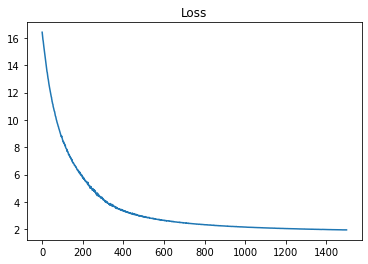

MAE_int:  0.08965492022701853
RMSE_int:  0.5988486293781377
MAE_float:  2.8887175903315585
RMSE_float:  3.041836320474346
For n_clusters = 6 the average silhouette score is : 0.04


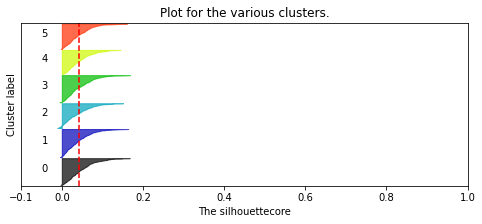

For n_clusters = 6 the average silhouette score is : 0.04


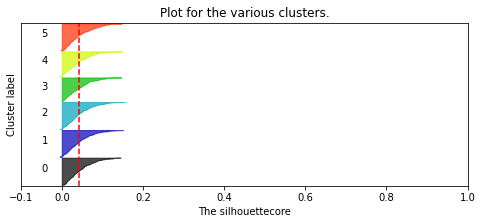

For n_clusters = 6 the average silhouette score is : 0.32


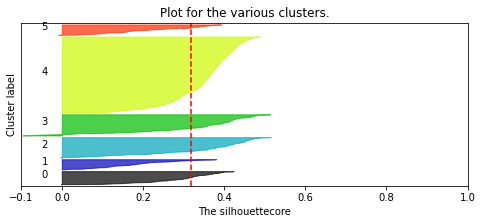

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = param_track[-1]

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

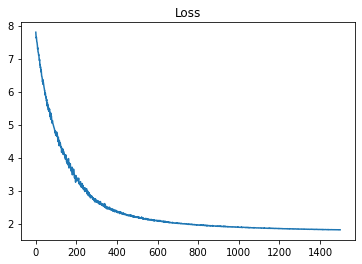

MAE_int:  0.05363003947983956
RMSE_int:  0.4631632087281526
MAE_float:  2.88224505662243
RMSE_float:  2.9670322979262167
For n_clusters = 6 the average silhouette score is : 0.08


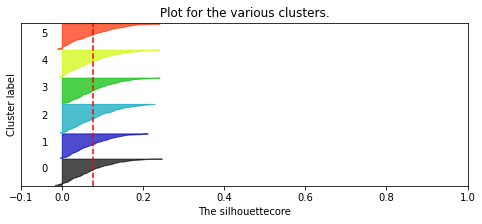

For n_clusters = 6 the average silhouette score is : 0.08


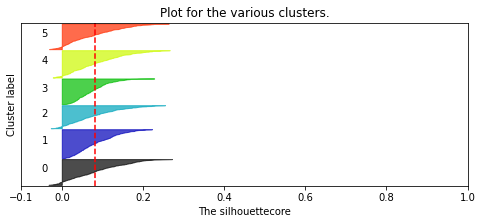

For n_clusters = 6 the average silhouette score is : 0.41


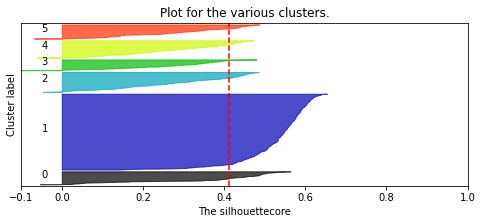

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = param_track[-1]

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

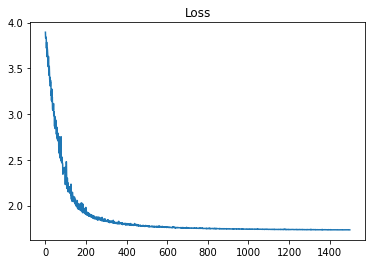

MAE*:  2.0963410220877785
RMSE*:  2.1916010431348774
For n_clusters = 6 the average silhouette score is : 0.14


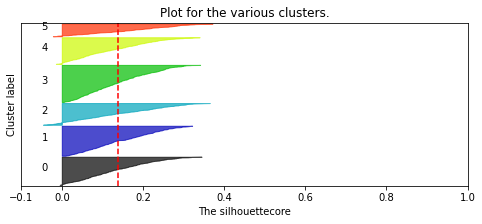

For n_clusters = 6 the average silhouette score is : 0.13


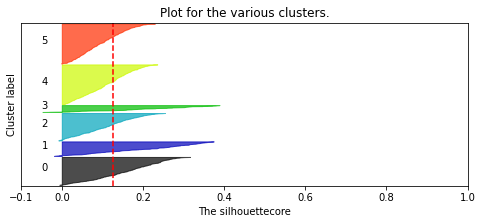

For n_clusters = 6 the average silhouette score is : 0.31


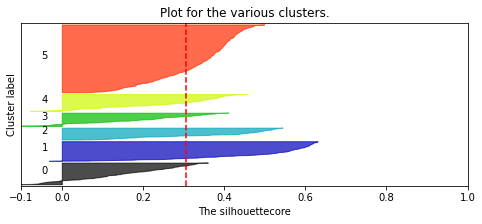

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = visualize_learning(param_track)

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

### Model-3

In [ ]:
class Neural_PMF_3(PyroModule):
    def __init__(self, Identity, latent=16, mean=0.0, sd=1.0):
        super().__init__()
        user_dim, item_dim = Identity.shape
        self.user_dim, self.item_dim, self.latent_dim = user_dim, item_dim, latent
        self.Identity = Identity

        self.logvar_V_param  = torch.nn.Parameter(torch.randn(self.latent_dim), requires_grad=True)
        self.logvar_W_param  = torch.nn.Parameter(torch.randn(self.latent_dim), requires_grad=True)
        self.logvar_U_param  = torch.nn.Parameter(torch.randn(self.latent_dim),requires_grad=True)
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.U, self.W, self.Y, self.R = None, None, None, None

    def generate(self, latent=16, mean=3.0, sd=0.15):
        self.V = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_V_param)).expand([self.item_dim, self.latent_dim]).to_event(2))
        self.W = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_W_param)).expand([self.item_dim, self.latent_dim]).to_event(2))
        self.Y = PyroSample(dist.Normal(loc=0.0, scale=torch.exp(0.5*self.logvar_U_param)).expand([self.user_dim, self.latent_dim]).to_event(2))
        avg_similarity_weight = torch.mm(self.Identity, self.W)
        self.U = self.Y + avg_similarity_weight
        self.mean_R = torch.sigmoid(torch.mm(self.U, self.V.T))
        self.R = PyroSample(dist.Normal(loc=self.mean_R, scale=torch.exp(0.5*self.logvar_R_param)))
        return self.R

    def get_param(self):
        return {'logvar_V_param':0.0+self.logvar_V_param.data.numpy(), 'logvar_W_param':0.0+self.logvar_W_param.data.numpy(),\
                'logvar_Y_param':0.0+self.logvar_U_param.data.numpy(), 'logvar_R_param':0.0+self.logvar_R_param.item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

In [ ]:
model = Neural_PMF_3(Identity)
loss_track, param_track = sgd_training(model, ELBO_Loss(), ratings, epochs=1500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 7.740048, RMSE = 1.323580 
+ Param:  {'logvar_V_param': array([-1.6492269 , -1.3964471 ,  0.49341643,  0.9523649 , -1.9805174 ,
       -0.5410414 , -0.17300299, -0.382234  , -0.15839773, -0.8876123 ,
       -2.77722   ,  2.0973728 , -0.3405749 ,  0.26496008, -2.0013492 ,
        2.0418048 ], dtype=float32), 'logvar_W_param': array([-0.881758  ,  1.557885  , -0.22047976, -0.8198047 ,  0.9324792 ,
        1.6645696 , -0.56076944,  0.7318896 , -0.20800412,  0.3891264 ,
        1.0689121 ,  0.04228945, -1.3547057 ,  1.0031652 ,  0.39094713,
        0.24324046], dtype=float32), 'logvar_Y_param': array([ 0.8749869 ,  0.14171143,  0.29393083,  0.15986194, -0.0148239 ,
        0.57459354, -0.6161904 ,  0.5566532 ,  0.8771813 , -0.83241874,
        0.44292516,  1.0773157 , -0.5294787 , -1.0339311 ,  0.6280038 ,
       -0.48322064], dtype=float32), 'logvar_R_param': 0.0}
Epoch 149: 
+ Loss = 3.921649, RMSE = 1.004573 
+ Param:  {'logvar_V_param': array([-2.9452991 , -2.844601 

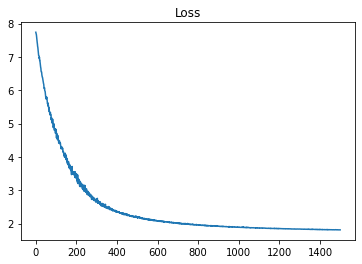

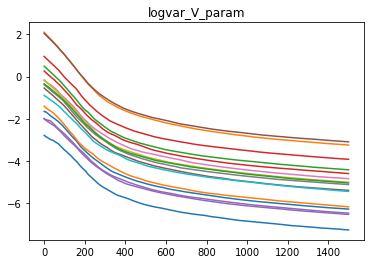

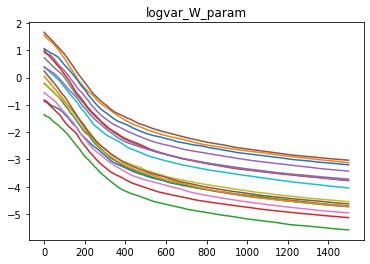

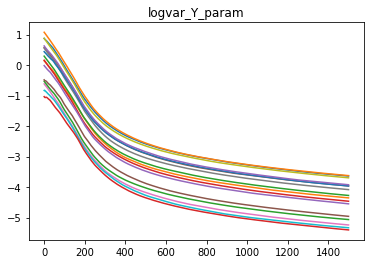

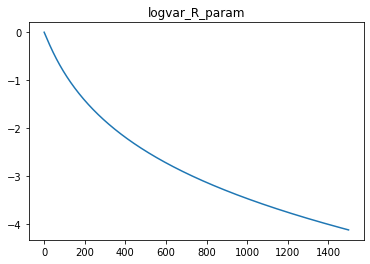

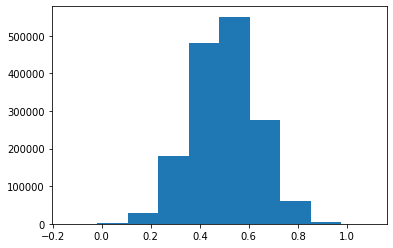

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

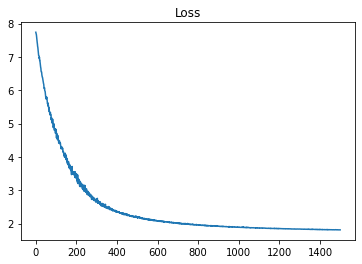

MAE_int:  0.05368299870249905
RMSE_int:  0.46339183722849087
MAE_float:  2.8821594581512677
RMSE_float:  2.9675080250667483
For n_clusters = 6 the average silhouette score is : 0.10


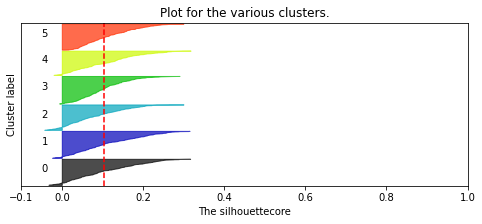

For n_clusters = 6 the average silhouette score is : 0.07


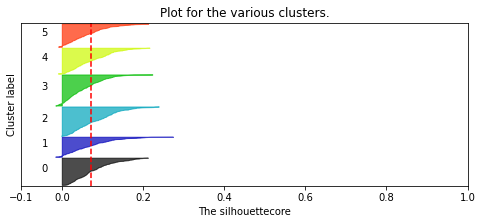

For n_clusters = 6 the average silhouette score is : 0.40


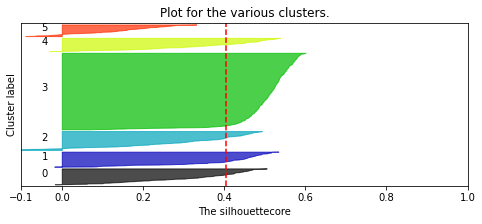

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = param_track[-1]

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

## 3.2 Reparameterize Trick with MCMC model

In [ ]:
from torch.distributions import LogNormal, Normal

In [ ]:
class Neural_PMF_RTrick(PyroModule):
    def __init__(self, Identity, latent=16, mean=0.0, sd=1.0):
        super().__init__()
        user_dim, item_dim = Identity.shape
        self.user_dim, self.item_dim, self.latent_dim = user_dim, item_dim, latent
        self.Identity = Identity

        self.logvar_V_param  = torch.nn.Parameter(torch.randn(self.latent_dim), requires_grad=True)
        self.logvar_W_param  = torch.nn.Parameter(torch.randn(self.latent_dim), requires_grad=True)
        self.logvar_U_param  = torch.nn.Parameter(torch.randn(self.latent_dim),requires_grad=True)
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

        # self.R = None

    def generate(self, latent=16, mean=3.0, sd=0.15):
        V = LogNormal(loc = torch.tensor(0.0), scale = (0.5 * self.logvar_V_param).exp()).rsample(sample_shape=[self.item_dim])
        W = LogNormal(loc = torch.tensor(0.0), scale = (0.5 * self.logvar_W_param).exp()).rsample(sample_shape=[self.item_dim])
        Y = LogNormal(loc = torch.tensor(0.0), scale = (0.5 * self.logvar_U_param).exp()).rsample(sample_shape=[self.user_dim])
        avg_similarity_weight = torch.mm(self.Identity, W)
        U = Y + avg_similarity_weight
        mean_R = torch.sigmoid(torch.mm(U, V.T))
        R = Normal(loc = mean_R, scale = (0.5 * self.logvar_R_param).exp()).rsample()
        return R
        # self.R = PyroSample(dist.Normal(loc=mean_R, scale=0.5*self.logvar_R_param.exp()))
        # return self.R

    def get_param(self):
        return {'logvar_V_param':0.0+self.logvar_V_param.data.numpy(), 'logvar_W_param':0.0+self.logvar_W_param.data.numpy(),\
                'logvar_Y_param':0.0+self.logvar_U_param.data.numpy(), 'logvar_R_param':0.0+self.logvar_R_param.item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

In [ ]:
model = Neural_PMF_RTrick(Identity)
loss_track, param_track = sgd_training(model, ELBO_Loss(), ratings, epochs=500)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Epoch 0: 
+ Loss = 10.801554, RMSE = 1.537353 
+ Param:  {'logvar_V_param': array([-1.5578946 ,  0.5383337 , -0.12814015,  1.4283407 ,  0.63878435,
        0.38795736,  2.0139084 ,  0.9880454 , -0.10901538,  0.6887069 ,
        0.51058066, -0.73340935, -2.260542  ,  0.16678955,  0.6449433 ,
       -0.69657236], dtype=float32), 'logvar_W_param': array([-1.2895491 , -0.46197358,  0.24161786, -1.7097113 , -1.1251366 ,
       -0.40071142,  0.46826026,  0.5933718 , -0.4322176 ,  0.22626518,
       -1.0073117 , -1.4381503 , -1.4038162 , -0.56017524,  0.7520574 ,
       -0.7911857 ], dtype=float32), 'logvar_Y_param': array([-1.2566031 ,  0.3263784 ,  0.8999853 ,  1.8439691 , -0.00819617,
        0.5678272 ,  3.038702  ,  0.01393909, -1.2874094 , -0.20197372,
        1.6728748 ,  0.29047942,  0.5517949 , -1.7805599 , -1.3260761 ,
        0.01127985], dtype=float32), 'logvar_R_param': 0.0}
Epoch 49: 
+ Loss = 8.655240, RMSE = 1.389900 
+ Param:  {'logvar_V_param': array([-1.6724241 ,  0.5638572

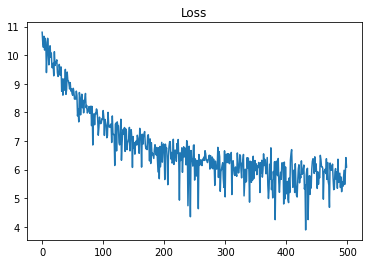

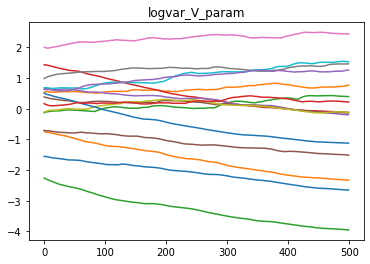

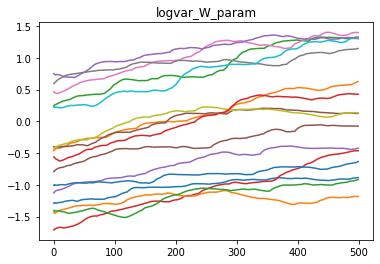

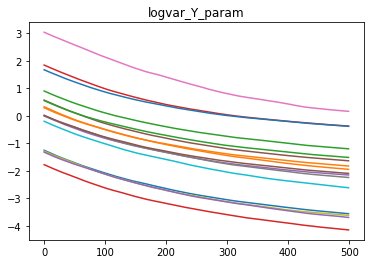

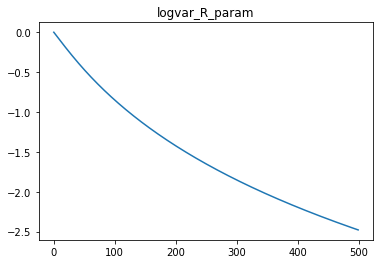

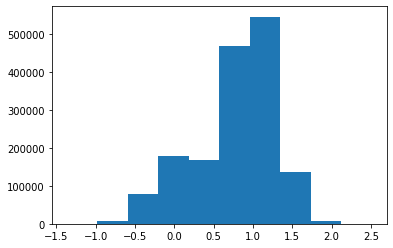

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

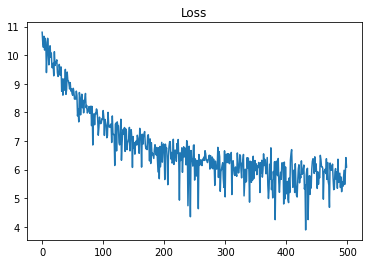

MAE_int:  0.948161747553473
RMSE_int:  1.9485024515419607
MAE_float:  3.05440754167335
RMSE_float:  3.6727200890016696
For n_clusters = 6 the average silhouette score is : 0.11


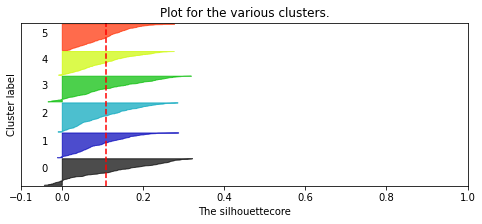

For n_clusters = 6 the average silhouette score is : 0.08


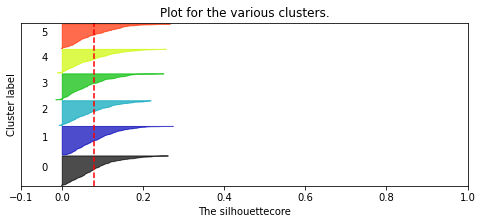

For n_clusters = 6 the average silhouette score is : 0.44


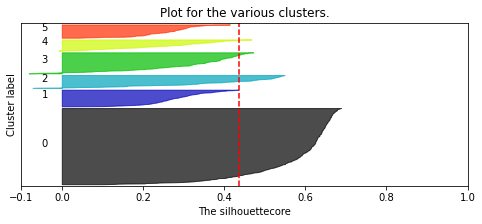

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = param_track[-1]

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

In [ ]:
model = Neural_PMF_RTrick(Identity)
loss_track, param_track = sgd_training(model, torch.nn.MSELoss(), ratings, epochs=500)

Epoch 0: 
+ Loss = 2.390147, RMSE = 1.505980 
+ Param:  {'logvar_V_param': array([ 1.5284772 ,  1.1515207 ,  0.8038701 ,  0.8184855 , -1.3958322 ,
       -0.71157223, -0.07140192, -0.47688234,  1.7527199 ,  1.9570963 ,
       -1.6099188 , -0.19665818, -0.33654067,  0.75958604, -0.04488456,
       -0.17619114], dtype=float32), 'logvar_W_param': array([-0.72392267, -0.6835935 , -1.2988896 ,  0.10675167,  0.4554602 ,
        1.4552187 ,  0.23614962, -0.9388621 , -0.49410176,  0.23444599,
        0.2072279 , -0.6677024 , -0.7465264 , -0.4837347 , -0.46487257,
       -1.2929333 ], dtype=float32), 'logvar_Y_param': array([ 1.2670472 ,  1.3570311 ,  0.8537621 , -0.22982687, -0.17879361,
        0.21724439,  1.1835514 , -0.9009731 ,  1.4510189 ,  1.007689  ,
       -0.8679492 ,  1.563434  , -0.2812945 , -0.21811032, -0.12307002,
        0.21396558], dtype=float32), 'logvar_R_param': 0.0}
Epoch 49: 
+ Loss = 1.982713, RMSE = 1.425835 
+ Param:  {'logvar_V_param': array([ 1.5326844 ,  1.1343108 

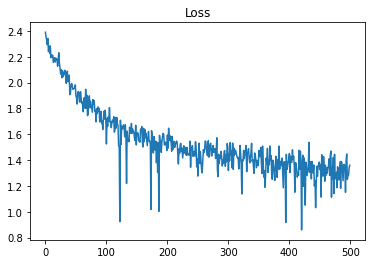

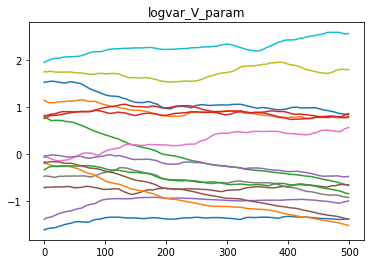

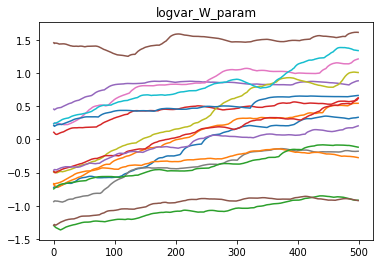

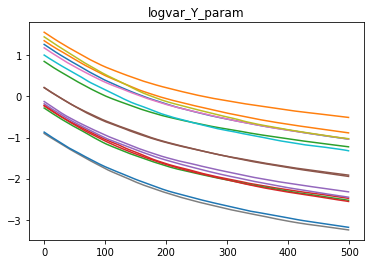

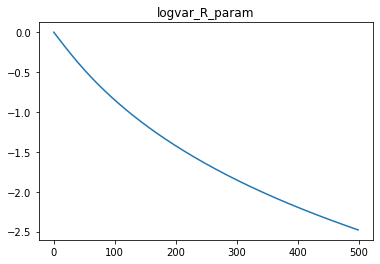

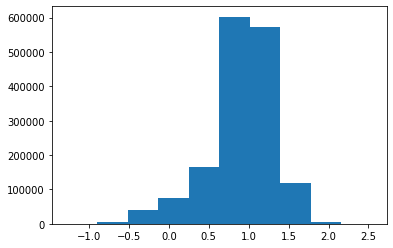

In [ ]:
visualize(loss_track, param_track, model.get_approx().data.numpy().reshape(-1, 1))

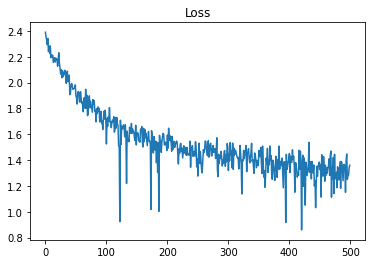

MAE_int:  0.9458391073596928
RMSE_int:  1.9459977438899312
MAE_float:  3.0529125351127626
RMSE_float:  3.670021052861016
For n_clusters = 6 the average silhouette score is : 0.10


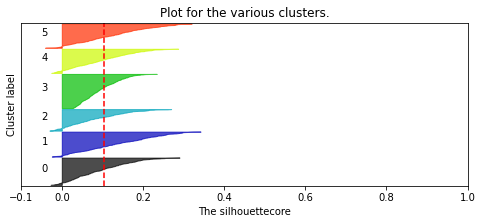

For n_clusters = 6 the average silhouette score is : 0.07


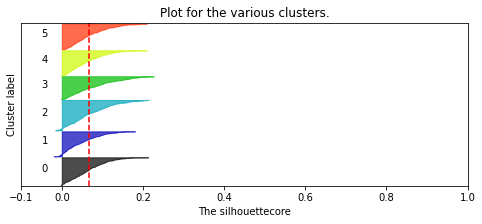

For n_clusters = 6 the average silhouette score is : 0.51


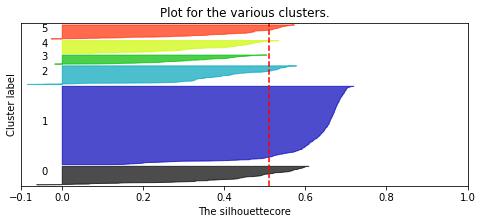

In [ ]:
import seaborn as sbn
sbn.lineplot(x = range(len(loss_track)), y = loss_track)
plt.title('Loss')
plt.show()

last_param = param_track[-1]

R, V, U, W, Y = get_values_from_tracker(Identity, K=16, param_dict=last_param)
print ('MAE_int: ',  np.mean(np.abs(invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))))
print ('RMSE_int: ',  np.sqrt(np.mean((invscale_minmax(R.astype(int), vmin, vmax)-invscale_minmax(ratings.data.numpy().astype(int), vmin, vmax))**2)))
print ('MAE_float: ',  np.mean(np.abs(invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))))
print ('RMSE_float: ',  np.sqrt(np.mean((invscale_minmax(R, vmin, vmax)-invscale_minmax(ratings.data.numpy(), vmin, vmax))**2)))

visualize_clusters(V)
visualize_clusters(W)
visualize_clusters(U)

## 3.3 InferNet: fail

In [ ]:
class InferNet(torch.nn.Module):
    #similar Demo_SGD_InferNet, but generate log_std instead std
    def __init__(self, his, dim = 1, n_sample= 1000):
        super(InferNet, self).__init__()
        self.his = his
        self.dim = dim
        self.n_sample = n_sample
        self.mean_fc = torch.nn.Linear(1, 1)
        self.var_fc = torch.nn.Linear(1, 1)
        self.phi, self.tau = None, None

    def generate(self):
        eps = scale_minmax(torch.randn(self.dim))-0.5
        x_hat = self.phi + torch.exp(self.tau) * 2 * eps
        return x_hat

    def forward(self):
        self.phi = torch.mean(self.mean_fc(self.his))
        self.tau = torch.mean(self.var_fc(self.his))
        self.x = self.generate()
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=3000):
        return self.x

In [ ]:
class PPL_MF(PyroModule):
    def __init__(self, user_dim, item_dim, latent=16, mean=1.0, sd=0.1):
        super(PPL_MF, self).__init__()
        self.user_dim, self.item_dim = user_dim, item_dim
        self.latent_dim = latent

        self.logvar_V_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.logvar_W_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.logvar_U_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.logvar_R_param  = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

        self.V, self.U, self.R = None, None, None
        self.W, self.Y = None, None
        self.const_meanV = torch.zeros(self.item_dim, self.latent_dim)
        self.const_meanU = torch.zeros(self.user_dim, self.latent_dim)

    def generate(self):
        V = (self.const_meanV, self.logvar_V_param, self.const_meanV.shape, self.n_sample)
        W = mcmc_sampling(self.const_meanV, self.logvar_W_param, self.const_meanV.shape, self.n_sample)
        Y = mcmc_sampling(self.const_meanU, self.logvar_U_param, self.const_meanU.shape, self.n_sample)
        avg_similarity_weight = torch.mm(Identity, W.view(self.item_dim, self.flat_dim)).view(self.user_dim, self.latent_dim, self.n_sample)
        U = Y + avg_similarity_weight
        mean_R = torch.sigmoid(torch.mm(U.view(self.user_dim, self.flat_dim), V.view(self.item_dim, self.flat_dim).T)).view(self.user_dim, self.item_dim)/ self.n_sample
        R_sampling = mcmc_sampling(mean_R, self.logvar_V_param, mean_R.shape, self.n_sample)
        self.R = torch.mean(R_sampling, keepdim=True, dim=2).view(self.user_dim, self.item_dim)
        return self.R

    def get_param(self):
        return {'logvar_V_param':torch.exp(self.logvar_V_param).item(), 'logvar_W_param':torch.exp(self.logvar_W_param).item(),\
                'logvar_Y_param':torch.exp(self.logvar_U_param).item(), 'logvar_R_param':torch.exp(self.logvar_R_param).item()}

    def forward(self):
        return self.generate()

    def get_approx(self, n_sample=300):
        return self.generate()

- https://pytutorial.marcoinacio.com/sections/vae/

- https://buildmedia.readthedocs.org/media/pdf/pyro-ppl/dev/pyro-ppl.pdf

- http://docs.pyro.ai/en/stable/distributions.html